In [3]:
import pandas as pd
dataset = pd.read_csv('/content/all_ac_questions.csv')
dataset.head()

,question,id,background,publish_time,close_time,tags,source_links,prediction_count,forecaster_count,answer,choices,status,qtype,crowd
0,What will the end-of-day closing value for the...,G1,Outcome will be determined by the end-of-day c...,2015-09-01 13:49:29.860000+00:00,2016-01-01 17:00:01+00:00,"['Finance', 'Economic Indicators']",['http://ftalphaville.ft.com/2015/08/17/213732...,1549.0,385,D,"['Less than 6.30', 'Between 6.30 and 6.35, inc...",Resolved,mc,"[{'timestamp': '2015-09-01 00:00:00+00:00', 'f..."
1,How many seats will the Justice and Developmen...,G2,The Justice and Development Party (AKP) failed...,2015-09-01 13:54:25.050000+00:00,2015-11-01 22:00:20+00:00,"['Elections and Referenda', 'Non-US Politics']",['http://www.al-monitor.com/pulse/originals/20...,567.0,194,A,"['A majority', 'A plurality', 'Not a plurality']",Resolved,mc,"[{'timestamp': '2015-09-01 00:00:00+00:00', 'f..."
2,Will there be an initial public offering on ei...,G4,China suspended initial public offerings (IPOs...,2015-09-01 13:58:30.138000+00:00,2015-11-30 14:00:15+00:00,['Finance'],['http://atimes.com/2015/11/china-will-allow-s...,545.0,148,yes,"['yes', 'no']",Resolved,t/f,"[{'timestamp': '2015-09-01 00:00:00+00:00', 'f..."
3,Will the Export-Import Bank of the United Stat...,G5,The Export-Import Bank's authorization expired...,2015-09-01 14:02:21.242000+00:00,2015-12-04 14:00:25+00:00,"['Economic Policy', 'US Politics', 'US Policy']",['http://thehill.com/policy/finance/260118-wee...,1000.0,379,yes,"['yes', 'no']",Resolved,t/f,"[{'timestamp': '2015-09-01 00:00:00+00:00', 'f..."
4,Will a trilateral meeting take place between C...,G6,"A trilateral meeting of leaders from China, Ja...",2015-09-01 14:04:41.470000+00:00,2015-12-31 23:00:11+00:00,['Foreign Policy'],"['https://en.wikipedia.org/wiki/Li_Keqiang', '...",946.0,385,no,"['yes', 'no']",Resolved,t/f,"[{'timestamp': '2015-09-01 00:00:00+00:00', 'f..."


In [4]:
features = ['question','background']
label = ['answer']

In [5]:
dataset= dataset[dataset['qtype'] == 't/f'][features + label]
dataset['answer'] = dataset['answer'].str.replace('no','0').str.replace('yes', '1')
dataset['text'] =  dataset['background'] + '\n' + dataset['question']
dataset['label'] = dataset['answer']
dataset = dataset.dropna().reset_index(drop = True)[['text','label']]
dataset['label'] = dataset['label'].astype(int)
dataset

,text,label
0,China suspended initial public offerings (IPOs...,1
1,The Export-Import Bank's authorization expired...,1
2,"A trilateral meeting of leaders from China, Ja...",0
3,For details of the case involving Jason Rezaia...,1
4,A launch for military or testing purposes woul...,1
...,...,...
1950,"Nationwide, new COVID-19 hospitalizations have...",1
1951,"Nationwide, new COVID-19 hospitalizations have...",0
1952,"On February 24, 2022, Russian President Vladim...",0
1953,"A previous Metaculus question asked ""at least ...",1


In [6]:
from datasets import Dataset
dataset = Dataset.from_pandas(dataset)

In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [8]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)
tokenized_dataset = dataset.map(preprocess_function, batched=True)

  0%|          | 0/2 [00:00<?, ?ba/s]

In [9]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [10]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [11]:
tokenized_dataset = tokenized_dataset.train_test_split(test_size = 0.3)

In [12]:
tf_train_set = model.prepare_tf_dataset(
    tokenized_dataset["train"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_validation_set = model.prepare_tf_dataset(
    tokenized_dataset["test"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [13]:
from transformers import create_optimizer
import tensorflow as tf

batch_size = 16
num_epochs = 5
batches_per_epoch = len(tokenized_dataset["train"]) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

In [14]:
import tensorflow as tf

model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [15]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=3)

Epoch 1/3
85/85 [==============================] - 88s 913ms/step - loss: 0.6043 - val_loss: 0.5851
Epoch 2/3
85/85 [==============================] - 77s 909ms/step - loss: 0.5497 - val_loss: 0.5691
Epoch 3/3
85/85 [==============================] - 79s 925ms/step - loss: 0.4740 - val_loss: 0.6005


In [22]:
history.history

{'loss': [0.6042740941047668, 0.5496629476547241, 0.4740102291107178],
 'val_loss': [0.5850554704666138, 0.5690667629241943, 0.6005229353904724]}

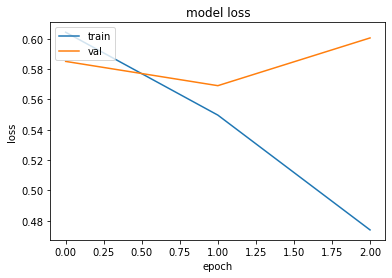

In [23]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [25]:
model.evaluate(tf_validation_set)

37/37 [==============================] - 10s 256ms/step - loss: 0.6005


0.6005229353904724